# Path 1: PM Strategy Execution & Completion Analysis
## INSY6500 - PM Analysis Project

**Analyst:** Mike Moyer

**Research Question:** *How do different departments approach preventative maintenance? Does it reveal anything about their operational philosophy?*

**Approach:** This notebook follows the EDA workflow to analyze the relationship between different departments and their planned PM activities.

---

* PHASE 0 - Data Loading
* PHASE I - Foundations
  * Feature Engineering `Intervals` & `Job Complexity`
  * Overall Summary for Baseline Condition
* PHASE II - Department Profiling
  * Workload Overview
  * Job Type Strategies
  * Personality Profiles
        

---

## PHASE 0 - Data Loading and Check

### 0.1 Setup & Data Loading

Import required libraries and load both datasets using the approach from the data loader template.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

print("Libraries imported")

Libraries imported


### 0.2 Define Data Path

In [2]:
# Define data directory
DATA_DIR = Path('../data')

# Define file paths
FORECAST_FILE = DATA_DIR / '103ki_pm_forecast.csv'

### 0.3 Load Forecast Data 

Scheduled PM activities for the coming fiscal year.

In [3]:
# Load future workload forecast data
df_forecast = pd.read_csv(FORECAST_FILE, 
                        encoding='cp1252',
                        parse_dates = ['DUE_DATE'],
                        dtype={
                            'INTERVAL': 'category',
                            'JOB_TYPE': 'category',
                            'LABOR_CRAFT': 'category',
                            'PMSCOPETYPE': 'category',
                            'DEPT': 'category',
                            'DEPT_NAME': 'category',
                            'DEPT_TYPE' : 'category',
                            'PLANT' : 'category',
                            'LINE' : 'category',
                            'ZONENAME' : 'category',
                            'PROCESSNAME' : 'category'
                        })

# Fix missing DEPT_NAME for Facilities departments
df_forecast['DEPT_NAME'] = np.where(
    df_forecast['DEPT'].str.startswith('FA', na=False) & df_forecast['DEPT_NAME'].isna(),
    'FACILITIES',
    df_forecast['DEPT_NAME']
)

print(f"Forecast data shape: {df_forecast.shape[0]:,} rows, {df_forecast.shape[1]} columns")

Forecast data shape: 99,983 rows, 23 columns


In [4]:
# Quick preview
print("First 3 rows of Forecast data:")
display(df_forecast.head(3))

First 3 rows of Forecast data:


,DUE_DATE,PMNUM,COUNTKEY,PMDESCRIPTION,INTERVAL,FORECASTJP,JOB_TYPE,LABOR_CRAFT,PLANNED_LABORERS,PLANNED_LABOR_HRS,...,PMSCOPETYPE,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME
0,2026-04-01,PM104088,2026-04-01-PM104088,LP DIE CAST MACHINE #4 PM - M,1-MONTHS,JP211217,INSPECTION,ESTMULT,1.0,1.750000,...,ASSET,3DCLCAA4XXMC,Casting Die Cast Machine 4 Machine,3,3DC,DIE CAST,DC,L,LP Casting,Casting Die Cast Machine 4
1,2026-04-01,PM104114,2026-04-01-PM104114,LPDC #1 PF DEBURR STATION 1M PM,1-MONTHS,JP211160,INSPECTION,ESTMULT,1.0,0.500000,...,ASSET,3DCLPF01XXPF,Pre-finish Line 1 Pre-finish,3,3DC,DIE CAST,DC,L,Pre-finish,Pre-finish Line 1
2,2026-04-01,PM104116,2026-04-01-PM104116,LPDC #1 PF INSPECTION STATION PM,1-MONTHS,JP211164,INSPECTION,ESTMULT,1.0,0.333333,...,ASSET,3DCLPF01XXPF,Pre-finish Line 1 Pre-finish,3,3DC,DIE CAST,DC,L,Pre-finish,Pre-finish Line 1


In [5]:
#quick data type / info & nun-null check
print("\n Data Types and Non-Null Counts:")
df_forecast.info()


 Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99983 entries, 0 to 99982
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DUE_DATE                99983 non-null  datetime64[ns]
 1   PMNUM                   99983 non-null  object        
 2   COUNTKEY                99983 non-null  object        
 3   PMDESCRIPTION           99983 non-null  object        
 4   INTERVAL                99983 non-null  category      
 5   FORECASTJP              99910 non-null  object        
 6   JOB_TYPE                99906 non-null  category      
 7   LABOR_CRAFT             92101 non-null  category      
 8   PLANNED_LABORERS        99154 non-null  float64       
 9   PLANNED_LABOR_HRS       99154 non-null  float64       
 10  TOTAL_MATERIAL_COST     1932 non-null   float64       
 11  TASK_COUNT              99983 non-null  int64         
 12  TOTAL_TASK_D

In [6]:
df_forecast.describe()

,DUE_DATE,PLANNED_LABORERS,PLANNED_LABOR_HRS,TOTAL_MATERIAL_COST,TASK_COUNT,TOTAL_TASK_DESC_LENGTH
count,99983,99154.000000,99154.000000,1932.000000,99983.000000,99879.000000
mean,2026-10-07 09:22:25.800785920,1.083264,1.758899,4252.804974,13.213386,631.310836
min,2026-04-01 00:00:00,1.000000,0.000000,0.630000,0.000000,3.000000
25%,2026-07-01 00:00:00,1.000000,0.500000,17.440000,5.000000,166.000000
50%,2026-09-30 00:00:00,1.000000,1.000000,205.740000,8.000000,346.000000
75%,2026-12-28 00:00:00,1.000000,1.750000,653.860000,15.000000,638.000000
max,2027-03-30 00:00:00,20.000000,499.750000,876095.000000,425.000000,16942.000000
std,NaN,0.867851,9.369430,40696.001503,15.315923,856.198784


## PHASE I - Foundations

**Focus:** Data prep & Feature Engineering

1. Parse `INTERVAL` into frequency groups - Clean the data into easy categories
2. Create a Job Plan Complexity metric - Some way of numerically understanding the complexity of the tasks being planned
4. Overall Summary Statistics - Create Baseline understanding before breaking out by department

### 1. Clean the Interval Column

The interval column has a mess of values that make it difficult to classify the PM frequency directly. It will need to be cleaned. 

* **Goal:** Parse the "12-MONTHS" strings into standardized categories
* **Method:** Extract Number & Unit -> convert to days -> bin into categories 

#### 1.1 Explore Interval Values

* Raw Interval Value counts (Display)
* Complete Interval List Delimited by Frequency and Unit (Saved as output)

In [7]:
#Unique interval values and their frequency
print("\n-> Unique Interval Values:")
interval_counts = df_forecast['INTERVAL'].value_counts().sort_index()
print(f"\n   Total unique intervals: {df_forecast['INTERVAL'].nunique()}")
print("\n   Top 20 most common intervals:")
display(interval_counts.head(20).to_frame())

# 3. Full sorted list for reference
# Extract numeric part
df_forecast['interval_number'] = df_forecast['INTERVAL'].str.extract(r'^(\d+)-')[0].astype(float)
df_forecast['interval_unit'] = df_forecast['INTERVAL'].str.extract(r'-([A-Z]+)$')[0]
print("\n-> Complete Interval List (sorted by unit then number):")
all_intervals = df_forecast.groupby(['interval_unit', 'interval_number']).size().reset_index(name='count')
all_intervals = all_intervals.sort_values(['interval_unit', 'interval_number'])

# Clean up temporary columns
df_forecast = df_forecast.drop(['interval_number', 'interval_unit'], axis=1)


-> Unique Interval Values:

   Total unique intervals: 47

   Top 20 most common intervals:


,count
INTERVAL,
1-DAYS,5980
1-MONTHS,33092
1-WEEKS,17475
1-YEARS,4811
10-WEEKS,5
10-YEARS,21
12-MONTHS,318
12-WEEKS,5
13-WEEKS,128



-> Complete Interval List (sorted by unit then number):


**Observations**

* Large range of interval options are noted
* Reduce to simplified categories for research and classification

In [8]:
# Save interval analysis for reference
OUTPUT_DIR = Path('../outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

# Save as both pickle and CSV
all_intervals.to_pickle(OUTPUT_DIR / 'interval_analysis.pkl')
all_intervals.to_csv(OUTPUT_DIR / 'interval_analysis.csv', index=False)

#### 1.2 Parsing Strategy
To overcome these differences in text / yet similarities in frequence I will reparse the data with by converting the Frequency Unit to days and multiply them by the frequency to normalize their frequency.  

The Conversion will be 

```python
conversion = {
    'DAYS': 1,
    'WEEKS': 7,
    'MONTHS': 30.42,  # Average month length
    'YEARS': 365.25   # Account for leap years
}
```

The Frequency Bands will be defined as such: 

|Band|Days|Note|
|---|---|---|
|Daily:| < 4 | Clear daily or sub-weekly activities |
|Weekly:| 4-10 | "once-a-week" bucket |
|Biweekly:| 11-20 | Greater than once a week, but less than every 2 weeks |
|Monthly:| 21-45 | "roughly once a month" concept, captures odd 45 day frequency intervals |
|Bi-Monthly| 46-75 | roughly every other month |
|Quarterly:| 76-135 | roughly every 3 - 4 months |
|Semi-Annual:|136-270 | Twice a year |
|Annual:| 271-540 | At least once a year but less than every 1.5 years |
|Multi-Year:| 541 | 1.5 year interval or more |


#### 1.3 `Interval` Parsing

In [9]:
# Extract numeric value and unit to temporary columns
df_forecast['interval_number'] = df_forecast['INTERVAL'].str.extract(r'^(\d+)-')[0].astype(float)
df_forecast['interval_unit'] = df_forecast['INTERVAL'].str.extract(r'-([A-Z]+)$')[0]

# Convert all intervals to days 
conversion_factors = {
    'DAYS': 1,
    'WEEKS': 7,
    'MONTHS': 30.42,  
    'YEARS': 365.25   
}

# New permanent column for interval days using .map()
df_forecast['interval_days'] = df_forecast['interval_number'] * df_forecast['interval_unit'].map(conversion_factors)

# Categorize into frequency bands using .cut()

# Define bin edges and labels
bins = [0, 3, 10, 20, 45, 75, 135, 270, 540, float('inf')]
labels = ['Daily', 'Weekly', 'Bi-Weekly', 'Monthly', 'Bi-Monthly', 
          'Quarterly', 'Semi-Annual', 'Annual', 'Multi-Year']

df_forecast['interval_category'] = pd.cut(
    df_forecast['interval_days'], 
    bins=bins, 
    labels=labels, 
    right=True  # Include right edge in each bin
)

# Check the categorization
print("\n-> Interval Category Distribution:")
category_dist = df_forecast['interval_category'].value_counts().sort_values(ascending=False)
display(category_dist.to_frame(name='PM_count'))

# Clean up temporary columns (keep interval_days and interval_category)
df_forecast = df_forecast.drop(['interval_number', 'interval_unit'], axis=1)



-> Interval Category Distribution:


,PM_count
interval_category,
Monthly,36425
Weekly,19494
Quarterly,14251
Semi-Annual,11838
Daily,5980
Annual,5148
Bi-Monthly,4631
Multi-Year,1246
Bi-Weekly,970


**Insight** 
 * Monthly PMs make up the majority of the work
 * Weekly, Quarterly, Semi-Anual are also more "regular"
 * It is expected that annual or multi-year would take less of the majority
 * Bi-Monthly and Bi-Weekly are obscure frequencies

---

### 2 Job Plan Complexity Calculations

**Goal:** Build a composite complexity score to compare job plan difficulty across departments

**Method:**
1. Handle missing values with realistic defaults (0.5hr for missing labor)
2. Aggregate labor hours correctly accounting for multiple crafts per PM occurrence
3. Calculate three normalized metrics: task count, labor hours, description length
4. Average together into single 0-1 complexity score
5. Create LOW/MEDIUM/HIGH thresholds for segmentation

**CRITICAL:** Must use `COUNTKEY` with `nunique()` to count PM occurrences correctly, since multiple crafts can be scheduled for the same PM occurrence (same PMNUM + same DUE_DATE)

I've included 2 metrics to approach job plan complexity:

* `task_count` : Which is the total number of tasks in a job plan
* `total_task_desc_length`: Total number of characters across all tasks

My concept here is that these two metrics can be used to add context to the labor hours and give us some sense of job complexity without having to interpret the words themselves. 

#### Approach

Caclulate: 

* **Task Density:** `tasks_per_hour = TASK_COUNT / PLANNED_LABOR_HOURS`
* **Description Intensity:** `desc_chars_per_task = TOTAL_TASK_DESC_LENGTH / TASK_COUNT`
* Overall Complexity Score which combines these


Considerations: 

*  Some important columns have NaN values. For this study I will replace with values that represent minimal work but not 0.... but these should be looked at within the source database.

*  We have `PLANNED_LABORERS` (number of people for the job) and `PLANNED_LABOR_HRS` (Hours Per Person) so we need the total hours of work:

    * `total_labor_hrs = PLANNED_LABORERS * PLANNED_LABOR_HRS`

#### 2.1 Handle Missing Values

In [10]:
# Verify no missing values remain
print("\n-> Missing Values Check:")
df_forecast[['TOTAL_TASK_DESC_LENGTH','PLANNED_LABOR_HRS','TASK_COUNT','PLANNED_LABORERS']].isna().sum()


-> Missing Values Check:


TOTAL_TASK_DESC_LENGTH    104
PLANNED_LABOR_HRS         829
TASK_COUNT                  0
PLANNED_LABORERS          829
dtype: int64

In [11]:
# Fill missing values with 0
df_forecast['TOTAL_TASK_DESC_LENGTH'] = df_forecast['TOTAL_TASK_DESC_LENGTH'].fillna(75) # Assume a null task would have some description 
df_forecast['PLANNED_LABOR_HRS'] = df_forecast['PLANNED_LABOR_HRS'].fillna(.5) # Assume a null plan takes some time... let's say 30 minutes
df_forecast['TASK_COUNT'] = df_forecast['TASK_COUNT'].fillna(1) # Assuming at least 1 task per job
df_forecast['PLANNED_LABORERS'] = df_forecast['PLANNED_LABORERS'].fillna(1) # Assuming at least 1 Laborer per job

# Verify no missing values remain
print("\n-> Missing Values Check:")
df_forecast[['TOTAL_TASK_DESC_LENGTH','PLANNED_LABOR_HRS','TASK_COUNT','PLANNED_LABORERS']].isna().sum()


-> Missing Values Check:


TOTAL_TASK_DESC_LENGTH    0
PLANNED_LABOR_HRS         0
TASK_COUNT                0
PLANNED_LABORERS          0
dtype: int64

#### 2.2 Calculate Total Planned Labor

We have `PLANNED_LABORERS` (number of people for the job) and `PLANNED_LABOR_HRS` (Hours Per Person) so we need the total hours of work:

* `total_labor_hrs = PLANNED_LABORERS * PLANNED_LABOR_HRS`

In [12]:
# Step 1: Total labor hours per row (laborers * hours per person)
df_forecast['total_labor_hrs'] = df_forecast['PLANNED_LABORERS'] * df_forecast['PLANNED_LABOR_HRS']

print("\n-> Sample calculation (first 10 rows):")
sample_cols = ['PMNUM', 'COUNTKEY', 'LABOR_CRAFT', 'PLANNED_LABORERS', 'PLANNED_LABOR_HRS', 'total_labor_hrs']
display(df_forecast[sample_cols].head(10))


-> Sample calculation (first 10 rows):


,PMNUM,COUNTKEY,LABOR_CRAFT,PLANNED_LABORERS,PLANNED_LABOR_HRS,total_labor_hrs
0,PM104088,2026-04-01-PM104088,ESTMULT,1.0,1.750000,1.750000
1,PM104114,2026-04-01-PM104114,ESTMULT,1.0,0.500000,0.500000
2,PM104116,2026-04-01-PM104116,ESTMULT,1.0,0.333333,0.333333
3,PM104131,2026-04-01-PM104131,CONGEN,1.0,8.000000,8.000000
4,PM104132,2026-04-01-PM104132,CONGEN,1.0,8.000000,8.000000
5,PM104160,2026-04-01-PM104160,CONGEN,1.0,0.500000,0.500000
6,PM104161,2026-04-01-PM104161,CONGEN,1.0,0.500000,0.500000
7,PM104240,2026-04-01-PM104240,CONGEN,1.0,1.500000,1.500000
8,PM104240,2026-04-01-PM104240,CONGEN,1.0,1.500000,1.500000
9,PM104240,2026-04-01-PM104240,CONGEN,1.0,1.500000,1.500000


#### 2.3 Aggregation of Labor

 `TASK_COUNT` and `TOTAL_TASK_DESC_LENGTH` are job plan attributes (same across all craft rows for a given `COUNTKEY`), but labor is split across crafts. So I will aggregate labor at the `COUNTKEY` level (per scheduled occurrence) to make it a job plan attribute.

In [13]:
# Aggregate total labor hours per PM occurrence (sum across all crafts)
df_forecast['total_labor_per_occurrence'] = df_forecast.groupby('COUNTKEY')['total_labor_hrs'].transform('sum')

# Find a COUNTKEY with multiple crafts to demonstrate
sample_countkey = df_forecast[df_forecast.duplicated('COUNTKEY', keep=False)]['COUNTKEY'].iloc[0]
sample_data = df_forecast[df_forecast['COUNTKEY'] == sample_countkey][
    ['COUNTKEY', 'PMNUM', 'LABOR_CRAFT', 'PLANNED_LABORERS', 'PLANNED_LABOR_HRS', 
     'total_labor_hrs', 'total_labor_per_occurrence', 'TASK_COUNT', 'TOTAL_TASK_DESC_LENGTH']
]
display(sample_data)


,COUNTKEY,PMNUM,LABOR_CRAFT,PLANNED_LABORERS,PLANNED_LABOR_HRS,total_labor_hrs,total_labor_per_occurrence,TASK_COUNT,TOTAL_TASK_DESC_LENGTH
7,2026-04-01-PM104240,PM104240,CONGEN,1.0,1.5,1.5,4.5,10,411.0
8,2026-04-01-PM104240,PM104240,CONGEN,1.0,1.5,1.5,4.5,10,411.0
9,2026-04-01-PM104240,PM104240,CONGEN,1.0,1.5,1.5,4.5,10,411.0


#### 2.4 Calculation of Complexity Metrics

* **Task Density:** `tasks_per_hour = TASK_COUNT / PLANNED_LABOR_HOURS`
* **Description Intensity:** `desc_chars_per_task = TOTAL_TASK_DESC_LENGTH / TASK_COUNT`


In [14]:
# Task density - tasks per labor hour (using aggregated occurrence-level hours)
df_forecast['task_density'] = np.where(
    df_forecast['total_labor_per_occurrence'] > 0,
    df_forecast['TASK_COUNT'] / df_forecast['total_labor_per_occurrence'],
    0
)

# Description intensity - characters per task
df_forecast['desc_intensity'] = np.where(
    df_forecast['TASK_COUNT'] > 0,
    df_forecast['TOTAL_TASK_DESC_LENGTH'] / df_forecast['TASK_COUNT'],
    0
)

print("\n-> Complexity Metrics Summary:")
metrics_summary = df_forecast[['task_density', 'desc_intensity', 'total_labor_per_occurrence']].describe()
display(metrics_summary)


-> Complexity Metrics Summary:


,task_density,desc_intensity,total_labor_per_occurrence
count,99983.000000,99983.000000,99983.000000
mean,14.067423,43.067874,2.232413
std,13.813784,15.517016,10.665645
min,0.000000,0.000000,0.000000
25%,5.000000,32.384615,0.500000
50%,10.000000,41.416667,1.000000
75%,18.000000,53.705882,2.000000
max,125.333333,100.000000,499.750000


**Here I have Identified an outlier that I will have to deal with** --- almost 500 hours on the labor per occurrence max value. I will have to clip that from the data but I will have to highlight it at the end. 

In [15]:
# Cap extreme values at 99th percentile
cap_value = df_forecast['total_labor_per_occurrence'].quantile(0.996)
df_forecast['total_labor_per_occ_capped'] = df_forecast['total_labor_per_occurrence'].clip(upper=cap_value)

print(f"\n-> Outlier Handling:")
print(f"   99th percentile: {cap_value:.2f} hours")
print(f"   Values above {cap_value:.2f} capped")
print(f"   Number of values capped: {(df_forecast['total_labor_per_occurrence'] > cap_value).sum()}")

print(cap_value)


-> Outlier Handling:
   99th percentile: 64.00 hours
   Values above 64.00 capped
   Number of values capped: 389
64.0


Output Clipped PMs for Later Reporting

In [16]:
# Create table of clipped PMs for reporting
clipped_pms = df_forecast[df_forecast['total_labor_per_occurrence'] > cap_value].copy()

# Get unique PMs with relevant details (drop duplicates since COUNTKEY repeats across crafts)
clipped_summary = clipped_pms.drop_duplicates('COUNTKEY')[
    ['PMNUM', 'COUNTKEY', 'PMDESCRIPTION', 'DEPT_NAME', 'INTERVAL', 
     'total_labor_per_occurrence', 'total_labor_per_occ_capped', 'TASK_COUNT']
].sort_values('total_labor_per_occurrence', ascending=False)

print("\n-> Clipped PMs Summary:")
display(clipped_summary)

# Save to outputs for reporting
OUTPUT_DIR = Path('../outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

clipped_summary.to_csv(OUTPUT_DIR / 'clipped_pms_report.csv', index=False)
print(f"\n Clipped PMs report saved to: {OUTPUT_DIR / 'clipped_pms_report.csv'}")


-> Clipped PMs Summary:


,PMNUM,COUNTKEY,PMDESCRIPTION,DEPT_NAME,INTERVAL,total_labor_per_occurrence,total_labor_per_occ_capped,TASK_COUNT
90487,PM165035,2027-02-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
82432,PM165035,2027-01-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
14356,PM165035,2026-05-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
64619,PM165035,2026-11-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
56543,PM165035,2026-10-28-PM165035,"MONTHLY, PA2 PRODUCTION SUPPORT",PAINT 2,1-MONTHS,499.75,64.0,4
...,...,...,...,...,...,...,...,...
91645,PM196453,2027-02-28-PM196453,Equipment Service Daily Activity for Richard C...,ENGINE ASSEMBLY,1-MONTHS,96.00,64.0,13
94755,PM175638,2027-03-27-PM175638,Equipment Service Daily Activity for Eric Ande...,ENGINE ASSEMBLY,1-MONTHS,96.00,64.0,13
99361,PM192956,2027-03-28-PM192956,Equipment Service Daily Activity for Amari Joh...,ENGINE ASSEMBLY,1-MONTHS,96.00,64.0,13
99429,PM196453,2027-03-28-PM196453,Equipment Service Daily Activity for Richard C...,ENGINE ASSEMBLY,1-MONTHS,96.00,64.0,13



 Clipped PMs report saved to: ..\outputs\clipped_pms_report.csv


#### 2.5  Composite Complexity Score

Average together the normalized `task_density`, `desc_intensity`, and `total_labor_per_occurrence` to get an overall complexity score.

In [17]:
# Complexity score (normalized composite)
# SKlearn min-max scaling
scaler = MinMaxScaler()

# Define complexity components
complexity_components = df_forecast[['task_density', 'total_labor_per_occ_capped', 'desc_intensity']]
normalized = scaler.fit_transform(complexity_components)

# Averaged together
df_forecast['complexity_score'] = normalized.mean(axis=1)

print("\n-> Complexity Score Summary:")
display(df_forecast['complexity_score'].describe())


-> Complexity Score Summary:


count    99983.000000
mean         0.190984
std          0.070845
min          0.002604
25%          0.138562
50%          0.178254
75%          0.237310
max          0.544250
Name: complexity_score, dtype: float64

---
Lets look at that Max Density PM and see if it makes sense.

In [18]:
# Find the PM with maximum task density (selected columns)
max_idx = df_forecast['task_density'].idxmax()
print("\n-> PM with Maximum Task Density:")
print(df_forecast.loc[max_idx, ['PMNUM', 'PMDESCRIPTION', 'task_density', 'TASK_COUNT', 'total_labor_per_occ_capped']])


-> PM with Maximum Task Density:
PMNUM                                                                  PM105581
PMDESCRIPTION                 LINE 1 TRANSFORMER TEMP & AMP READINGS FRIDAY ...
task_density                                                         125.333333
TASK_COUNT                                                                  188
total_labor_per_occ_capped                                                  1.5
Name: 347, dtype: object


Finally, it appears to match the database! (took 3 long tries)

---

In [19]:
# Save normalized components as separate columns for visualization
df_forecast['task_norm'] = normalized[:, 0]  # First column
df_forecast['hours_norm'] = normalized[:, 1]  # Second column
df_forecast['desc_norm'] = normalized[:, 2]  # Third column

#### 2.6 Low Medium High Thresholds

With Complexity scores in place, I will use quartile ranges to set a threshold for Low, Medium, and High complexity: 

* 0-25% = Low
* 26-50% = Medium
* 51-100% = High

In [20]:
# Get quartile thresholds for later use
low_threshold = df_forecast['complexity_score'].quantile(0.25)
mid_threshold = df_forecast['complexity_score'].quantile(0.50)
high_threshold = df_forecast['complexity_score'].quantile(0.75)

print(f"\n-> Complexity Score Quartiles:")
print(f"   25th percentile: {low_threshold:.3f}")
print(f"   50th percentile: {mid_threshold:.3f}")
print(f"   75th percentile: {high_threshold:.3f}")

# Categorize using quartile thresholds
df_forecast['complexity_level'] = pd.cut(
    df_forecast['complexity_score'],
    bins=[0, low_threshold, high_threshold, 1.0],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)


-> Complexity Score Quartiles:
   25th percentile: 0.139
   50th percentile: 0.178
   75th percentile: 0.237


In [39]:
print("\n-> Sanity Check:")
sample_cols = ['PMNUM', 'COUNTKEY', 'interval_category', 'FORECASTJP', 'total_labor_per_occurrence','hours_norm', 'TASK_COUNT', 'task_density','task_norm', 'TOTAL_TASK_DESC_LENGTH','desc_intensity', 'complexity_level']
display(df_forecast[sample_cols].head(10))


-> Sanity Check:


,PMNUM,COUNTKEY,interval_category,FORECASTJP,total_labor_per_occurrence,hours_norm,TASK_COUNT,task_density,task_norm,TOTAL_TASK_DESC_LENGTH,desc_intensity,complexity_level
0,PM104088,2026-04-01-PM104088,Monthly,JP211217,1.750000,0.027344,8,4.571429,0.036474,419.0,52.375000,Medium
1,PM104114,2026-04-01-PM104114,Monthly,JP211160,0.500000,0.007812,4,8.000000,0.063830,120.0,30.000000,Low
2,PM104116,2026-04-01-PM104116,Monthly,JP211164,0.333333,0.005208,3,9.000000,0.071809,75.0,25.000000,Low
3,PM104131,2026-04-01-PM104131,Daily,JP211381,8.000000,0.125000,27,3.375000,0.026928,1013.0,37.518519,Medium
4,PM104132,2026-04-01-PM104132,Daily,JP211381,8.000000,0.125000,27,3.375000,0.026928,1013.0,37.518519,Medium
5,PM104160,2026-04-01-PM104160,Daily,JP211371,0.500000,0.007812,4,8.000000,0.063830,256.0,64.000000,Medium
6,PM104161,2026-04-01-PM104161,Daily,JP211371,0.500000,0.007812,4,8.000000,0.063830,256.0,64.000000,Medium
7,PM104240,2026-04-01-PM104240,Weekly,JP211461,4.500000,0.070312,10,2.222222,0.017730,411.0,41.100000,Medium
8,PM104240,2026-04-01-PM104240,Weekly,JP211461,4.500000,0.070312,10,2.222222,0.017730,411.0,41.100000,Medium
9,PM104240,2026-04-01-PM104240,Weekly,JP211461,4.500000,0.070312,10,2.222222,0.017730,411.0,41.100000,Medium


**ITERATION NOTE**  
Looking at these values, for example:

* **PM104114** .5 labor per occurance (low-mid), with 8 tasks per hour (fast), with 30 characters per description (low) = Low complexity
* **PM104131** 8 labor (high), with 3.37 tasks per hour (pretty slow), with 37.5 characters per task description (mid-low) = Medium

I think it makes enough sense to move forward. Taking the outliers off the top balanced the weight of the `hours_norm` a little bit better than it had been. 

*might need to further tune task norm, description has a hard boundary at the top and bottom*  

#### 2.7 Complexity Visualization

1. KDE of normalized components - inspect the distributions of the 3 complexity components
2. Complexity by interval - Reveal patterns if there are patterns of complexity in the intervals

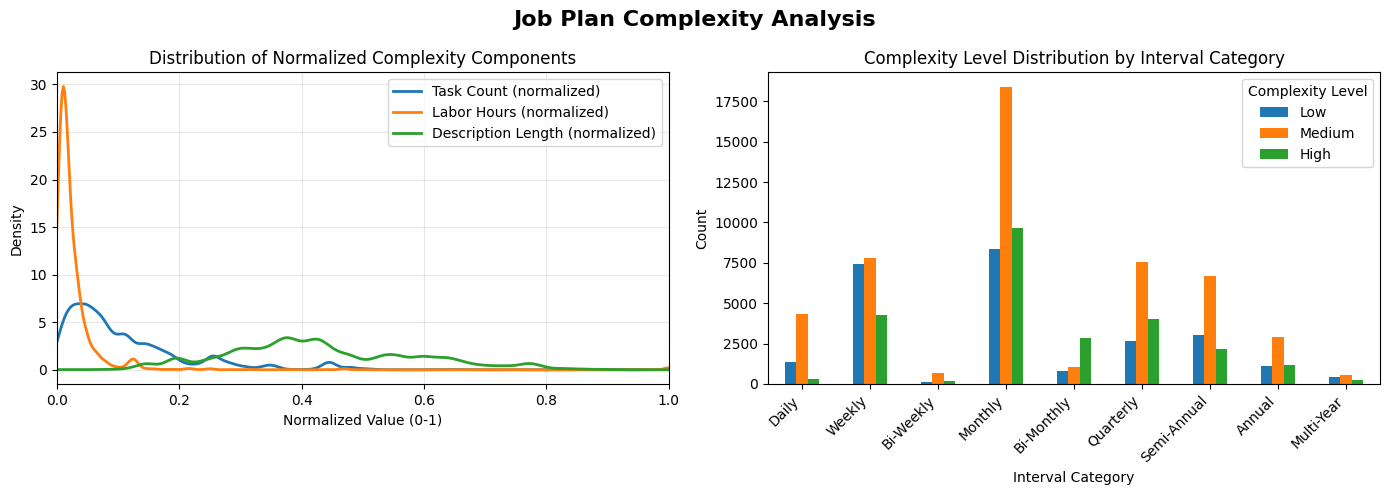

In [22]:
# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Job Plan Complexity Analysis', fontsize=16, fontweight='bold')

# Chart 1: KDE of Normalized Components
ax1 = axes[0]
df_forecast['task_norm'].plot(kind='kde', ax=ax1, linewidth=2, label='Task Count (normalized)')
df_forecast['hours_norm'].plot(kind='kde', ax=ax1, linewidth=2, label='Labor Hours (normalized)')
df_forecast['desc_norm'].plot(kind='kde', ax=ax1, linewidth=2, label='Description Length (normalized)')
ax1.set_xlabel('Normalized Value (0-1)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Normalized Complexity Components')
ax1.set_xlim(0, 1)
ax1.legend()
ax1.grid(alpha=0.3)

# Chart 2: Complexity Level by Interval Category
ax2 = axes[1]
complexity_by_interval = df_forecast.groupby(['interval_category', 'complexity_level'], observed = False).size().unstack(fill_value=0)
complexity_by_interval.plot(kind='bar', ax=ax2, stacked=False)
ax2.set_xlabel('Interval Category')
ax2.set_ylabel('Count')
ax2.set_title('Complexity Level Distribution by Interval Category')
ax2.legend(title='Complexity Level')
ax2.tick_params(axis='x', rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Data Quality Discoveries:**
- Missing labor hours handled with 0.5hr default (typical quick inspection time)
- Extreme outliers in planned labor were winsorized at 99th percentile to prevent score distortion

**Business Insight:** HIGH complexity PMs (score >70) represent major maintenance events requiring special planning attention and resource allocation

**Further Analysis/Tuning** Outliers were only handled with planned labor, but the other two metrics did not recieve the same inspection. This could be a source for future analysis or tuning. 

**Ready for:** Department comparison using standardized complexity metric

### 3. Overall Summary Statistics and Visualization

**Purpose:** Section 3 establishes the baseline for the whole site prior to comparing departments in Phase II. The idea is to reveal plant-wide patterns. We will look at 5 pattern areas: 

1) Job Type Distribution
2) Scope Type Distribution
3) Labor Craft Distribution
4) Interval Category Distribution
5) Complexity Level Distribution

#### 3.1 Job Type Distribution: 

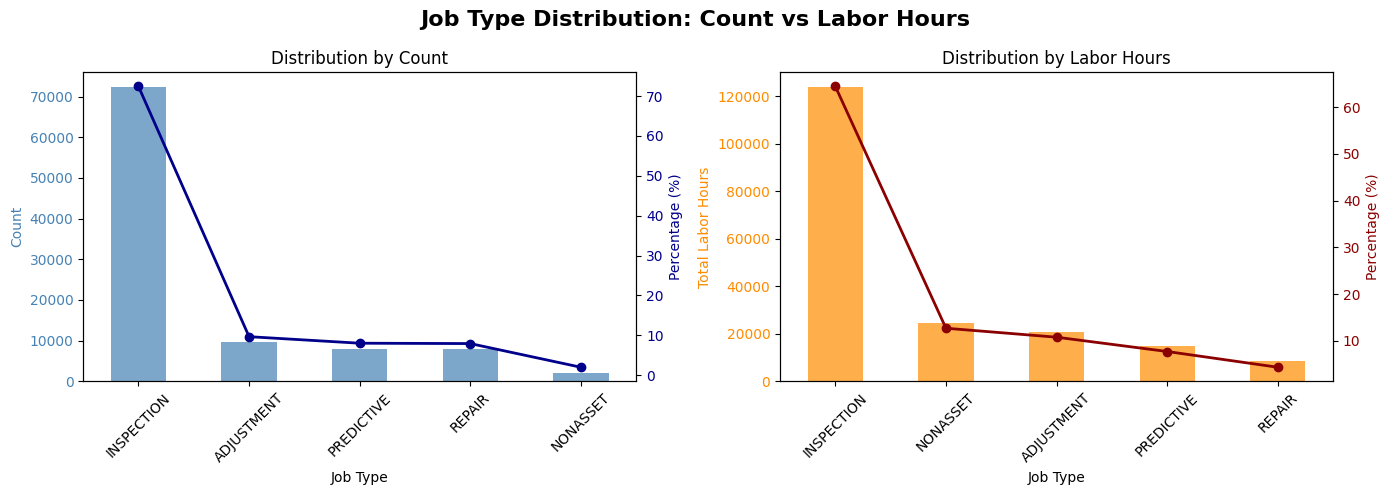


-> Job Type Summary:


,count,count_pct,total_hours,hours_pct
JOB_TYPE,,,,
ADJUSTMENT,9638,9.65,20718.533333,10.78
INSPECTION,72363,72.43,123830.066667,64.45
NONASSET,1982,1.98,24392.750000,12.70
PREDICTIVE,8007,8.01,14838.400000,7.72
REPAIR,7916,7.92,8356.133333,4.35


In [23]:
# Count and percentage of each job type
job_type_counts = df_forecast['JOB_TYPE'].value_counts().sort_values(ascending=False)
job_type_pct = (job_type_counts / job_type_counts.sum() * 100).round(2)

# Labor hours by job type
job_type_labor = df_forecast.groupby('JOB_TYPE', observed = False)['total_labor_per_occ_capped'].sum().sort_values(ascending=False)
job_type_labor_pct = (job_type_labor / job_type_labor.sum() * 100).round(2)


# Create side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Job Type Distribution: Count vs Labor Hours', fontsize=16, fontweight='bold')

# Chart 1: Count (bars) + Percentage (line)
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Bars for count
job_type_counts.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Job Type')
ax1.set_ylabel('Count', color='steelblue')
ax1.set_title('Distribution by Count')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.tick_params(axis='x', rotation=45)

# Line for percentage
job_type_pct.plot(kind='line', ax=ax1_twin, color='darkblue', marker='o', linewidth=2)
ax1_twin.set_ylabel('Percentage (%)', color='darkblue')
ax1_twin.tick_params(axis='y', labelcolor='darkblue')

# Chart 2: Labor Hours (bars) + Percentage (line)
ax2 = axes[1]
ax2_twin = ax2.twinx()

# Bars for labor hours
job_type_labor.plot(kind='bar', ax=ax2, color='darkorange', alpha=0.7)
ax2.set_xlabel('Job Type')
ax2.set_ylabel('Total Labor Hours', color='darkorange')
ax2.set_title('Distribution by Labor Hours')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.tick_params(axis='x', rotation=45)

# Line for percentage
job_type_labor_pct.plot(kind='line', ax=ax2_twin, color='darkred', marker='o', linewidth=2)
ax2_twin.set_ylabel('Percentage (%)', color='darkred')
ax2_twin.tick_params(axis='y', labelcolor='darkred')

plt.tight_layout()
plt.show()

# Print summary table
print("\n-> Job Type Summary:")
summary = pd.DataFrame({
    'count': job_type_counts,
    'count_pct': job_type_pct,
    'total_hours': job_type_labor,
    'hours_pct': job_type_labor_pct
})
display(summary)

#### 3.2  Scope Type Distribution

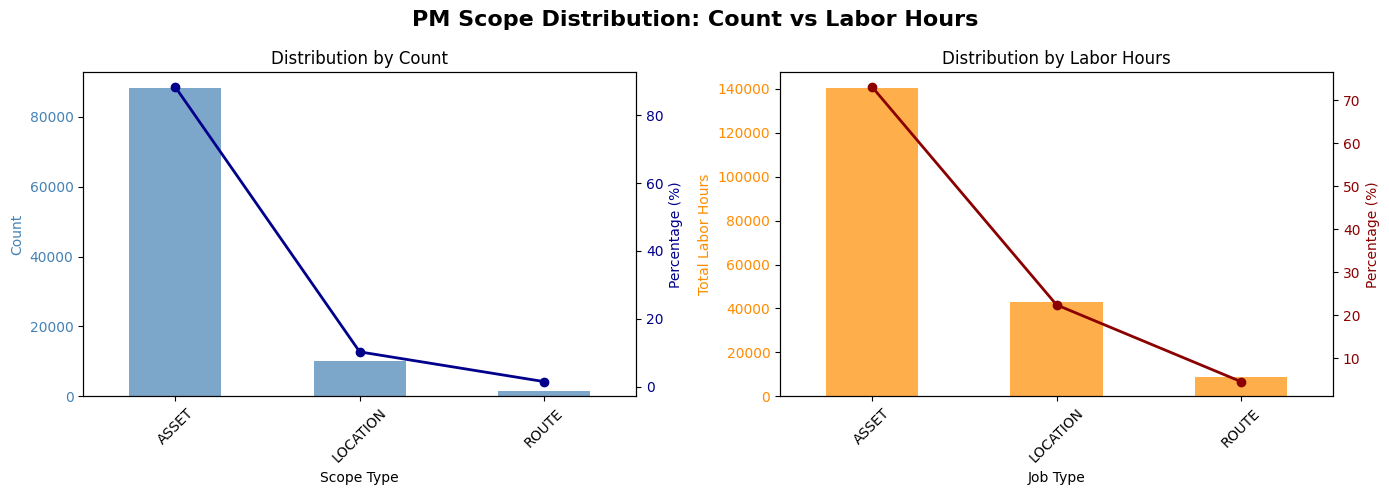


-> Scope Type Distribution:


,count,percentage,total_hours,hours_pct
PMSCOPETYPE,,,,
ASSET,88299,88.31,140502.766667,73.11
LOCATION,10225,10.23,43013.450000,22.38
ROUTE,1459,1.46,8658.166667,4.51


In [24]:
# Count and percentage
scope_counts = df_forecast['PMSCOPETYPE'].value_counts()
scope_pct = (scope_counts / scope_counts.sum() * 100).round(2)

# Labor hours by job type
scope_labor = df_forecast.groupby('PMSCOPETYPE', observed = False)['total_labor_per_occ_capped'].sum().sort_values(ascending=False)
scope_labor_pct = (scope_labor / scope_labor.sum() * 100).round(2)

# Create side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PM Scope Distribution: Count vs Labor Hours', fontsize=16, fontweight='bold')

# Chart 1: Count (bars) + Percentage (line)
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Bars for count
scope_counts.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Scope Type')
ax1.set_ylabel('Count', color='steelblue')
ax1.set_title('Distribution by Count')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.tick_params(axis='x', rotation=45)

# Line for percentage
scope_pct.plot(kind='line', ax=ax1_twin, color='darkblue', marker='o', linewidth=2)
ax1_twin.set_ylabel('Percentage (%)', color='darkblue')
ax1_twin.tick_params(axis='y', labelcolor='darkblue')

# Chart 2: Labor Hours (bars) + Percentage (line)
ax2 = axes[1]
ax2_twin = ax2.twinx()

# Bars for labor hours
scope_labor.plot(kind='bar', ax=ax2, color='darkorange', alpha=0.7)
ax2.set_xlabel('Job Type')
ax2.set_ylabel('Total Labor Hours', color='darkorange')
ax2.set_title('Distribution by Labor Hours')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.tick_params(axis='x', rotation=45)

# Line for percentage
scope_labor_pct.plot(kind='line', ax=ax2_twin, color='darkred', marker='o', linewidth=2)
ax2_twin.set_ylabel('Percentage (%)', color='darkred')
ax2_twin.tick_params(axis='y', labelcolor='darkred')

plt.tight_layout()
plt.show()


scope_summary = pd.DataFrame({
    'count': scope_counts,
    'percentage': scope_pct,
    'total_hours' : scope_labor,
    'hours_pct' : scope_labor_pct
})

print("\n-> Scope Type Distribution:")
display(scope_summary)

#### 3.3 Labor Craft Distribution

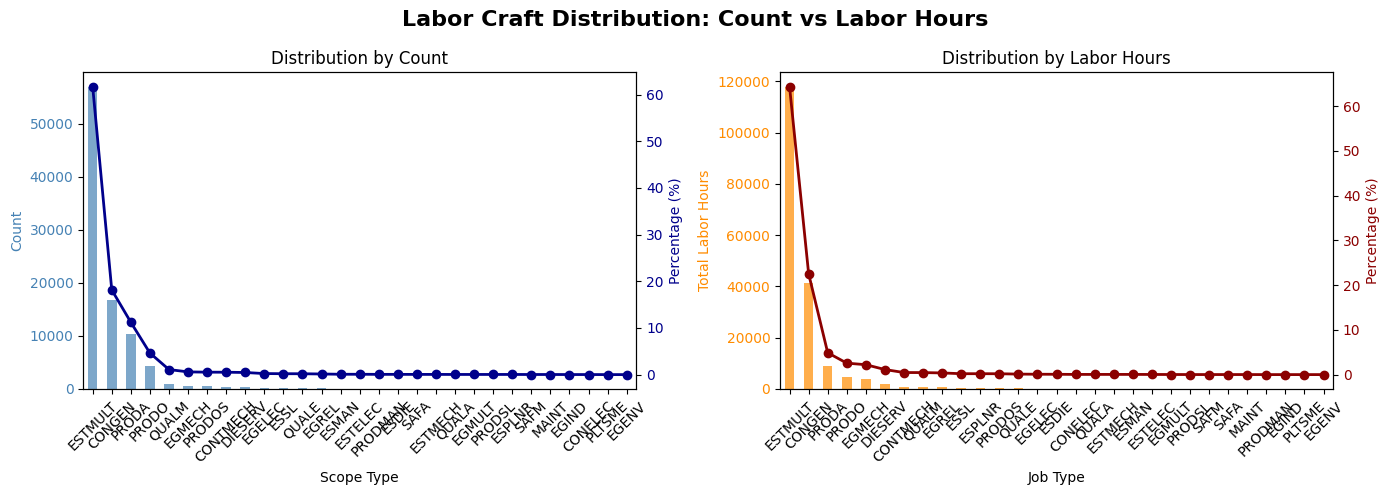


-> Total unique crafts: 29

-> Lavor Craft Distribution:


,count,percentage,total_hours,hours_pct
LABOR_CRAFT,,,,
CONGEN,16718,18.15,41227.616667,22.53
CONTMECH,467,0.51,850.500000,0.46
DIESERV,412,0.45,2063.000000,1.13
EGELEC,204,0.22,149.633333,0.08
EGIND,12,0.01,6.000000,0.00
EGMECH,532,0.58,4045.950000,2.21
EGMULT,29,0.03,41.700000,0.02
EGREL,120,0.13,675.166667,0.37
ESDIE,42,0.05,126.000000,0.07


In [25]:
# Top crafts by occurrence count
craft_counts = df_forecast['LABOR_CRAFT'].value_counts()
craft_pct = (craft_counts / craft_counts.sum() * 100).round(2)

# Labor hours by job type
craft_labor = df_forecast.groupby('LABOR_CRAFT', observed = False)['total_labor_per_occ_capped'].sum().sort_values(ascending=False)
craft_labor_pct = (craft_labor / craft_labor.sum() * 100).round(2)

# Create side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Labor Craft Distribution: Count vs Labor Hours', fontsize=16, fontweight='bold')

# Chart 1: Count (bars) + Percentage (line)
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Bars for count
craft_counts.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Scope Type')
ax1.set_ylabel('Count', color='steelblue')
ax1.set_title('Distribution by Count')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.tick_params(axis='x', rotation=45)

# Line for percentage
craft_pct.plot(kind='line', ax=ax1_twin, color='darkblue', marker='o', linewidth=2)
ax1_twin.set_ylabel('Percentage (%)', color='darkblue')
ax1_twin.tick_params(axis='y', labelcolor='darkblue')

# Chart 2: Labor Hours (bars) + Percentage (line)
ax2 = axes[1]
ax2_twin = ax2.twinx()

# Bars for labor hours
craft_labor.plot(kind='bar', ax=ax2, color='darkorange', alpha=0.7)
ax2.set_xlabel('Job Type')
ax2.set_ylabel('Total Labor Hours', color='darkorange')
ax2.set_title('Distribution by Labor Hours')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.tick_params(axis='x', rotation=45)

# Line for percentage
craft_labor_pct.plot(kind='line', ax=ax2_twin, color='darkred', marker='o', linewidth=2)
ax2_twin.set_ylabel('Percentage (%)', color='darkred')
ax2_twin.tick_params(axis='y', labelcolor='darkred')

plt.tight_layout()
plt.show()

print(f"\n-> Total unique crafts: {df_forecast['LABOR_CRAFT'].nunique()}")


craft_summary = pd.DataFrame({
    'count': craft_counts,
    'percentage': craft_pct,
    'total_hours' : craft_labor,
    'hours_pct' : craft_labor_pct
})

print("\n-> Lavor Craft Distribution:")
display(craft_summary)

#### 3.4 Interval Category Distribution

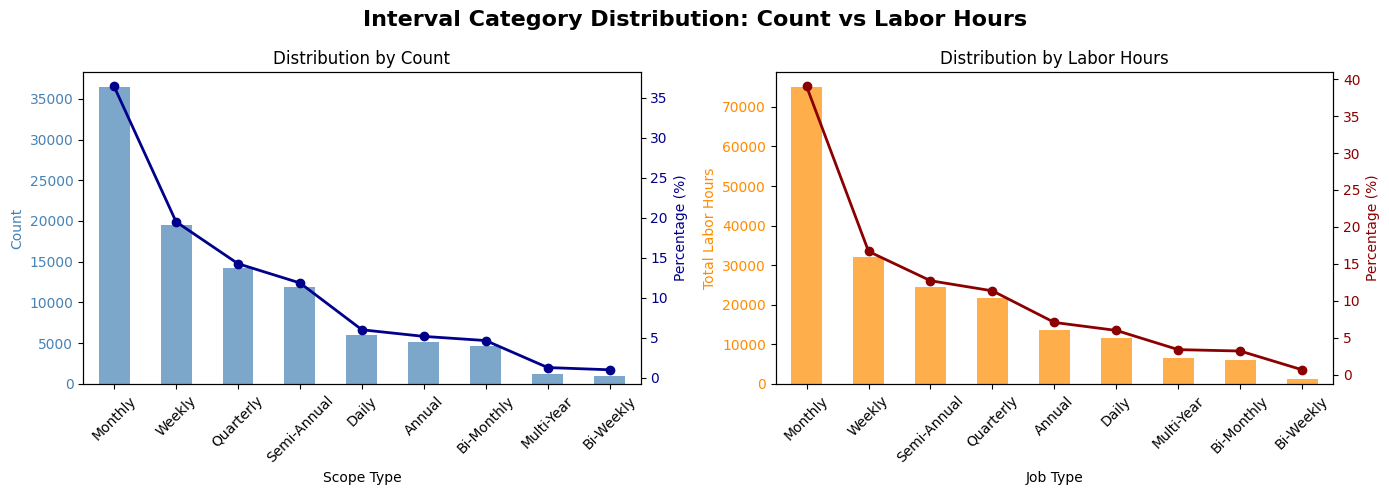


-> Total unique Intervals: 9

-> Lavor Craft Distribution:


,count,percentage,total_hours,hours_pct
interval_category,,,,
Daily,5980,5.98,11492.000000,5.98
Weekly,19494,19.50,32047.000000,16.68
Bi-Weekly,970,0.97,1252.000000,0.65
Monthly,36425,36.43,74967.250000,39.01
Bi-Monthly,4631,4.63,6137.383333,3.19
Quarterly,14251,14.25,21791.150000,11.34
Semi-Annual,11838,11.84,24418.383333,12.71
Annual,5148,5.15,13572.666667,7.06
Multi-Year,1246,1.25,6496.550000,3.38


In [26]:
# Distribution of interval categories
interval_counts = df_forecast['interval_category'].value_counts()
interval_pct = (interval_counts / interval_counts.sum() * 100).round(2)

# Interval catergory hours by job type
interval_labor = df_forecast.groupby('interval_category', observed = False)['total_labor_per_occ_capped'].sum().sort_values(ascending=False)
interval_labor_pct = (interval_labor / interval_labor.sum() * 100).round(2)

# Create side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Interval Category Distribution: Count vs Labor Hours', fontsize=16, fontweight='bold')

# Chart 1: Count (bars) + Percentage (line)
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Bars for count
interval_counts.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Scope Type')
ax1.set_ylabel('Count', color='steelblue')
ax1.set_title('Distribution by Count')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.tick_params(axis='x', rotation=45)

# Line for percentage
interval_pct.plot(kind='line', ax=ax1_twin, color='darkblue', marker='o', linewidth=2)
ax1_twin.set_ylabel('Percentage (%)', color='darkblue')
ax1_twin.tick_params(axis='y', labelcolor='darkblue')

# Chart 2: Labor Hours (bars) + Percentage (line)
ax2 = axes[1]
ax2_twin = ax2.twinx()

# Bars for labor hours
interval_labor.plot(kind='bar', ax=ax2, color='darkorange', alpha=0.7)
ax2.set_xlabel('Job Type')
ax2.set_ylabel('Total Labor Hours', color='darkorange')
ax2.set_title('Distribution by Labor Hours')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.tick_params(axis='x', rotation=45)

# Line for percentage
interval_labor_pct.plot(kind='line', ax=ax2_twin, color='darkred', marker='o', linewidth=2)
ax2_twin.set_ylabel('Percentage (%)', color='darkred')
ax2_twin.tick_params(axis='y', labelcolor='darkred')

plt.tight_layout()
plt.show()

print(f"\n-> Total unique Intervals: {df_forecast['interval_category'].nunique()}")


interval_summary = pd.DataFrame({
    'count': interval_counts,
    'percentage': interval_pct,
    'total_hours' : interval_labor,
    'hours_pct' : interval_labor_pct
})

print("\n-> Lavor Craft Distribution:")
display(interval_summary)

#### 3.5 Complexity Level Distribution

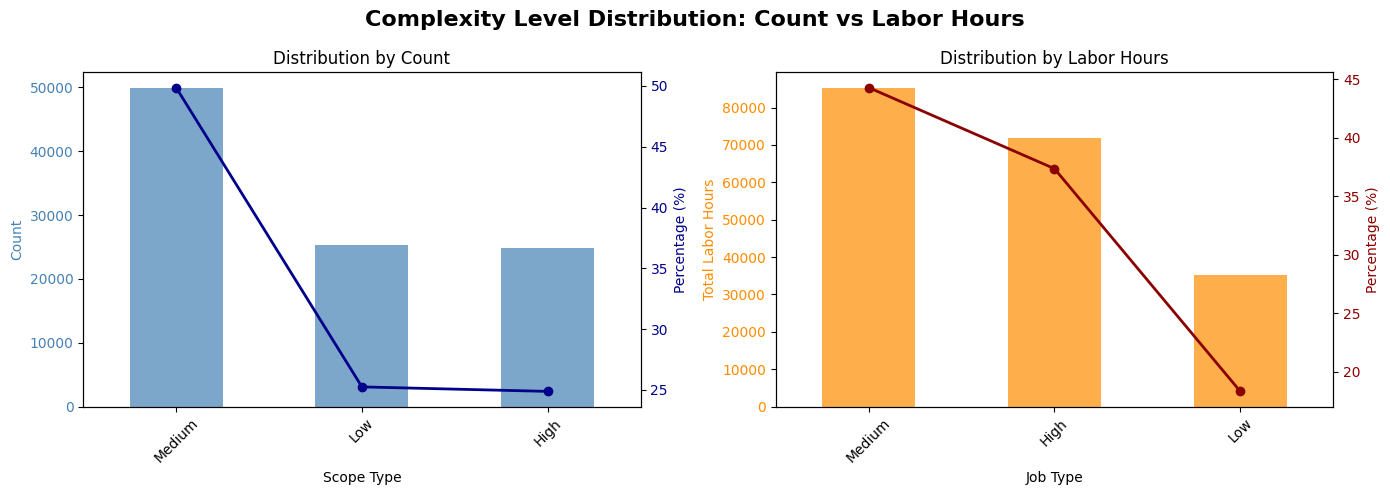


-> Total unique complexity levels: 3

-> Complexity Distribution:


,count,percentage,total_hours,hours_pct
complexity_level,,,,
Low,25247,25.25,35207.050000,18.32
Medium,49865,49.87,85160.516667,44.31
High,24871,24.88,71806.816667,37.37


In [27]:
# Distribution across complexity levels
complexity_counts = df_forecast['complexity_level'].value_counts()
complexity_pct = (complexity_counts / complexity_counts.sum() * 100).round(2)

# Labor hours by job type
complexity_labor = df_forecast.groupby('complexity_level', observed = False)['total_labor_per_occ_capped'].sum().sort_values(ascending=False)
complexity_labor_pct = (complexity_labor / complexity_labor.sum() * 100).round(2)

# Create side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Complexity Level Distribution: Count vs Labor Hours', fontsize=16, fontweight='bold')

# Chart 1: Count (bars) + Percentage (line)
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Bars for count
complexity_counts.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Scope Type')
ax1.set_ylabel('Count', color='steelblue')
ax1.set_title('Distribution by Count')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.tick_params(axis='x', rotation=45)

# Line for percentage
complexity_pct.plot(kind='line', ax=ax1_twin, color='darkblue', marker='o', linewidth=2)
ax1_twin.set_ylabel('Percentage (%)', color='darkblue')
ax1_twin.tick_params(axis='y', labelcolor='darkblue')

# Chart 2: Labor Hours (bars) + Percentage (line)
ax2 = axes[1]
ax2_twin = ax2.twinx()

# Bars for labor hours
complexity_labor.plot(kind='bar', ax=ax2, color='darkorange', alpha=0.7)
ax2.set_xlabel('Job Type')
ax2.set_ylabel('Total Labor Hours', color='darkorange')
ax2.set_title('Distribution by Labor Hours')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.tick_params(axis='x', rotation=45)

# Line for percentage
complexity_labor_pct.plot(kind='line', ax=ax2_twin, color='darkred', marker='o', linewidth=2)
ax2_twin.set_ylabel('Percentage (%)', color='darkred')
ax2_twin.tick_params(axis='y', labelcolor='darkred')

plt.tight_layout()
plt.show()

print(f"\n-> Total unique complexity levels: {df_forecast['complexity_level'].nunique()}")


complexity_summary = pd.DataFrame({
    'count': complexity_counts,
    'percentage': complexity_pct,
    'total_hours' : complexity_labor,
    'hours_pct' : complexity_labor_pct
})

print("\n-> Complexity Distribution:")
display(complexity_summary)

## PHASE II: Differentiate Departmental Approaches

---

### 4. Department PM Volumne and Labor


#### 4.1 Aggregation at `DEPT_NAME` level

In [28]:
# Aggregate at department level
dept_workload = df_forecast.groupby('DEPT_NAME', observed = False).agg({
    'COUNTKEY': 'nunique',  # Total unique PM occurrences
    'PMNUM': 'nunique',  # Total unique PMs
    'total_labor_per_occ_capped': 'sum'  # Total labor hours
}).rename(columns={
    'COUNTKEY': 'total_pm_occurrences',
    'PMNUM': 'unique_pms',
    'total_labor_per_occ_capped': 'total_labor_hours'
})

# Calculate average hours per PM occurrence
dept_workload['avg_hours_per_occurrence'] = (
    dept_workload['total_labor_hours'] / dept_workload['total_pm_occurrences']
).round(2)

# Sort by total labor hours (descending)
dept_workload = dept_workload.sort_values('total_labor_hours', ascending=False)

print("\n-> Department Workload Summary:")
display(dept_workload)


-> Department Workload Summary:


,total_pm_occurrences,unique_pms,total_labor_hours,avg_hours_per_occurrence
DEPT_NAME,,,,
FACILITIES,14540,1689,33452.500000,2.30
WELD 1,12381,3914,27154.966667,2.19
PAINT 2,10296,1327,24351.050000,2.37
WELD 2,15891,4334,22723.716667,1.43
ENGINE ASSEMBLY,6820,1566,22035.833333,3.23
STAMPING,3024,566,10842.800000,3.59
FRAME ASSEMBLY 2,3810,1047,9964.500000,2.62
MACHINING,4673,788,8430.250000,1.80
PAINT 1,4464,1267,8082.550000,1.81


#### 4.2 Visualization - Department Workload Comparison

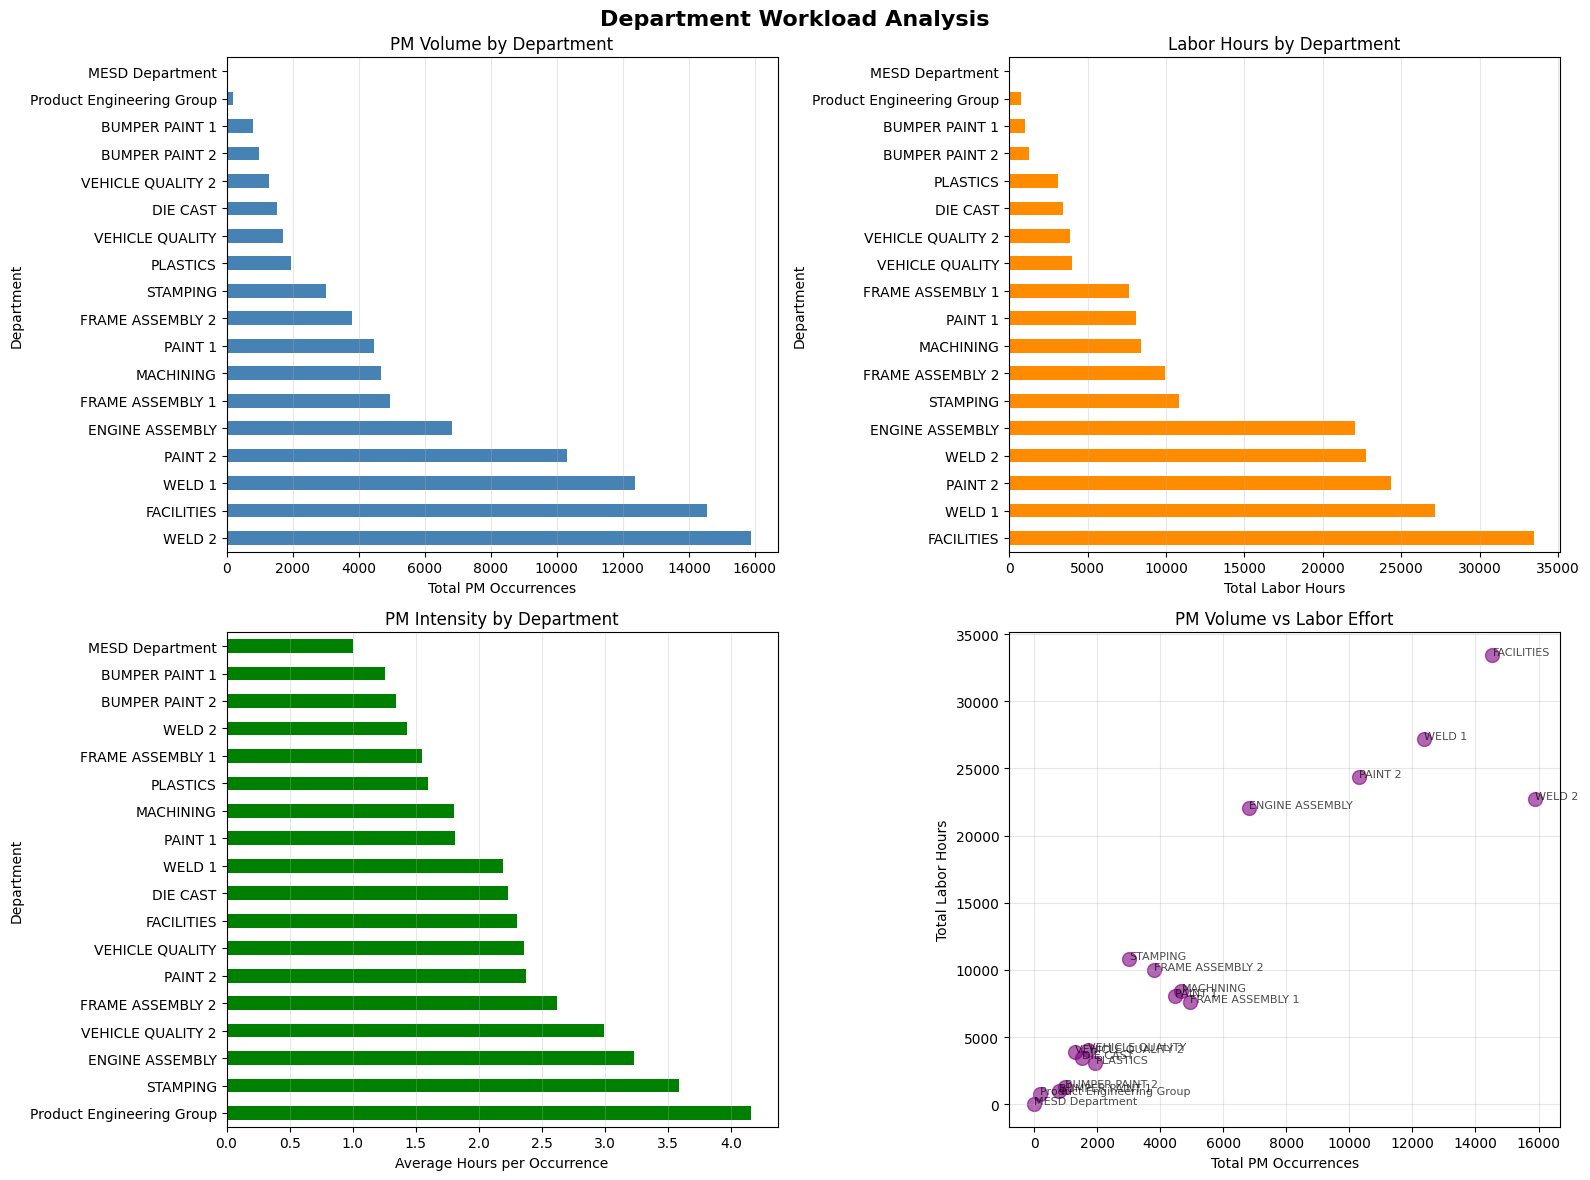

In [29]:
# Create 2x2 grid of charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Department Workload Analysis', fontsize=16, fontweight='bold')

# Chart 1: Total PM Occurrences by Department
ax1 = axes[0, 0]
dept_workload_sorted_workload = dept_workload.sort_values('total_pm_occurrences', ascending=False)
dept_workload_sorted_workload['total_pm_occurrences'].plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Total PM Occurrences')
ax1.set_ylabel('Department')
ax1.set_title('PM Volume by Department')
ax1.grid(axis='x', alpha=0.3)

# Chart 2: Total Labor Hours by Department
ax2 = axes[0, 1]
dept_workload_sorted_total = dept_workload.sort_values('total_labor_hours', ascending=False)
dept_workload_sorted_total['total_labor_hours'].plot(kind='barh', ax=ax2, color='darkorange')
ax2.set_xlabel('Total Labor Hours')
ax2.set_ylabel('Department')
ax2.set_title('Labor Hours by Department')
ax2.grid(axis='x', alpha=0.3)

# Chart 3: Average Hours per Occurrence
ax3 = axes[1, 0]
dept_workload_sorted_avg = dept_workload.sort_values('avg_hours_per_occurrence', ascending=False)
dept_workload_sorted_avg['avg_hours_per_occurrence'].plot(kind='barh', ax=ax3, color='green')
ax3.set_xlabel('Average Hours per Occurrence')
ax3.set_ylabel('Department')
ax3.set_title('PM Intensity by Department')
ax3.grid(axis='x', alpha=0.3)

# Chart 4: Scatter - Occurrences vs Labor Hours
ax4 = axes[1, 1]
ax4.scatter(dept_workload['total_pm_occurrences'], 
            dept_workload['total_labor_hours'],
            s=100, alpha=0.6, color='purple')
ax4.set_xlabel('Total PM Occurrences')
ax4.set_ylabel('Total Labor Hours')
ax4.set_title('PM Volume vs Labor Effort')
ax4.grid(alpha=0.3)

# Add department labels to scatter plot
for idx, row in dept_workload.iterrows():
    ax4.annotate(idx, 
                (row['total_pm_occurrences'], row['total_labor_hours']),
                fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

### 5. Job Type Strategy by Department
#### 5.1 Count-based and Labor-Weighted Distribution

* Job Type Distribution Count
* Job Type Distribution Count Percentage (Displayed)
* Job Type Labor Sum
* Job Type Labor Sum Percentage (Displayed)

In [30]:
# Count-based distribution
job_type_counts = df_forecast.groupby(['DEPT_NAME', 'JOB_TYPE'], observed = False).size().unstack(fill_value=0)
job_type_pct = job_type_counts.div(job_type_counts.sum(axis=1), axis=0) * 100

# Labor-weighted distribution
job_type_labor = df_forecast.groupby(['DEPT_NAME', 'JOB_TYPE'], observed = False)['total_labor_per_occ_capped'].sum().unstack(fill_value=0)
job_type_labor_pct = job_type_labor.div(job_type_labor.sum(axis=1), axis=0) * 100

print("\n-> Job Type Mix by Department (Count %):")
display(job_type_pct.round(2))

print("\n-> Job Type Mix by Department (Labor Hours %):")
display(job_type_labor_pct.round(2))


-> Job Type Mix by Department (Count %):


JOB_TYPE,ADJUSTMENT,INSPECTION,NONASSET,PREDICTIVE,REPAIR
DEPT_NAME,,,,,
BUMPER PAINT 1,23.89,36.03,0.00,39.57,0.51
BUMPER PAINT 2,22.30,46.32,3.92,0.98,26.47
DIE CAST,53.88,43.42,1.64,1.05,0.00
ENGINE ASSEMBLY,8.99,74.11,4.47,12.43,0.00
FACILITIES,17.41,74.14,4.62,3.73,0.11
FRAME ASSEMBLY 1,8.80,77.33,2.18,11.69,0.00
FRAME ASSEMBLY 2,6.00,73.76,0.00,18.57,1.68
MACHINING,2.12,92.64,0.25,4.98,0.00
MESD Department,0.00,0.00,100.00,0.00,0.00



-> Job Type Mix by Department (Labor Hours %):


JOB_TYPE,ADJUSTMENT,INSPECTION,NONASSET,PREDICTIVE,REPAIR
DEPT_NAME,,,,,
BUMPER PAINT 1,15.39,34.16,0.00,50.05,0.40
BUMPER PAINT 2,39.45,37.62,1.62,0.93,20.38
DIE CAST,55.62,39.57,3.69,1.12,0.00
ENGINE ASSEMBLY,3.01,25.60,63.02,8.37,0.00
FACILITIES,7.46,79.02,7.54,5.81,0.18
FRAME ASSEMBLY 1,6.61,73.61,0.35,19.42,0.00
FRAME ASSEMBLY 2,8.15,69.15,0.00,22.06,0.64
MACHINING,20.56,77.03,0.07,2.34,0.00
MESD Department,0.00,0.00,100.00,0.00,0.00


#### 5.2 Interval Strategy by Department

* Interval Distribution Count
* Interval Distribution Percentage (Displayed)
* Average Interval Days (Displayed)

In [31]:
# Distribution of interval categories per department
interval_dist = df_forecast.groupby(['DEPT_NAME', 'interval_category'],observed = False).size().unstack(fill_value=0)
interval_pct = interval_dist.div(interval_dist.sum(axis=1), axis=0) * 100

print("\n-> Interval Category Distribution by Department (%):")
display(interval_pct.round(2))

# Average interval days per department
avg_interval = df_forecast.groupby('DEPT_NAME', observed = False)['interval_days'].mean().sort_values(ascending=False)

print("\n-> Average Interval (days) by Department:")
display(avg_interval.round(2).to_frame(name='avg_interval_days'))


-> Interval Category Distribution by Department (%):


interval_category,Daily,Weekly,Bi-Weekly,Monthly,Bi-Monthly,Quarterly,Semi-Annual,Annual,Multi-Year
DEPT_NAME,,,,,,,,,
BUMPER PAINT 1,0.00,0.00,0.00,37.93,6.83,24.27,22.76,6.07,2.15
BUMPER PAINT 2,0.00,0.00,0.00,68.63,0.00,18.95,9.97,2.45,0.00
DIE CAST,0.00,26.46,0.00,50.38,0.38,16.73,3.31,2.35,0.38
ENGINE ASSEMBLY,0.00,18.21,0.38,47.12,0.18,8.42,17.66,6.83,1.20
FACILITIES,40.81,20.84,3.07,15.85,2.62,6.03,6.36,4.37,0.05
FRAME ASSEMBLY 1,0.00,19.92,0.00,55.40,1.09,11.35,10.00,1.79,0.44
FRAME ASSEMBLY 2,0.00,5.45,0.68,37.39,7.54,23.54,18.80,5.24,1.36
MACHINING,0.00,0.00,0.00,64.90,6.81,19.34,6.41,2.06,0.48
MESD Department,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00



-> Average Interval (days) by Department:


,avg_interval_days
DEPT_NAME,
MESD Department,365.25
FRAME ASSEMBLY 2,142.10
WELD 2,129.66
WELD 1,126.90
PAINT 1,118.13
BUMPER PAINT 1,115.85
Product Engineering Group,103.85
ENGINE ASSEMBLY,91.90
STAMPING,80.78


#### 5.3 Scope Type Preference by Department

* PM Scope Type by Count
* PM Scope Type by Percentage (Displayed)

In [32]:
# ASSET vs LOCATION distribution
scope_dist = df_forecast.groupby(['DEPT_NAME', 'PMSCOPETYPE'], observed = False).size().unstack(fill_value=0)
scope_pct = scope_dist.div(scope_dist.sum(axis=1), axis=0) * 100

print("\n-> Scope Type Distribution by Department (%):")
display(scope_pct.round(2))


-> Scope Type Distribution by Department (%):


PMSCOPETYPE,ASSET,LOCATION,ROUTE
DEPT_NAME,,,
BUMPER PAINT 1,99.75,0.00,0.25
BUMPER PAINT 2,92.40,5.96,1.63
DIE CAST,82.06,17.94,0.00
ENGINE ASSEMBLY,65.69,33.76,0.55
FACILITIES,98.94,1.06,0.00
FRAME ASSEMBLY 1,96.21,3.33,0.46
FRAME ASSEMBLY 2,97.75,0.10,2.15
MACHINING,99.60,0.40,0.00
MESD Department,0.00,100.00,0.00


#### 5.4 Job Complexity Profiles

* Average Complexity Score (Displayed)
* Complexity Distribution
* Complexity Distribution Percentage (Displayed)

In [33]:
# Average complexity score per department
avg_complexity = df_forecast.groupby('DEPT_NAME',observed = False)['complexity_score'].mean().sort_values(ascending=False)

print("\n-> Average Complexity Score by Department:")
display(avg_complexity.round(3).to_frame(name='avg_complexity_score'))

# Distribution of complexity levels per department
complexity_dist = df_forecast.groupby(['DEPT_NAME', 'complexity_level'],observed = False).size().unstack(fill_value=0)
complexity_pct = complexity_dist.div(complexity_dist.sum(axis=1), axis=0) * 100

print("\n-> Complexity Level Distribution by Department (%):")
display(complexity_pct.round(2))



-> Average Complexity Score by Department:


,avg_complexity_score
DEPT_NAME,
VEHICLE QUALITY,0.294
VEHICLE QUALITY 2,0.293
WELD 1,0.239
STAMPING,0.238
WELD 2,0.218
Product Engineering Group,0.209
FRAME ASSEMBLY 1,0.193
PAINT 1,0.176
FACILITIES,0.169



-> Complexity Level Distribution by Department (%):


complexity_level,Low,Medium,High
DEPT_NAME,,,
BUMPER PAINT 1,25.41,73.32,1.26
BUMPER PAINT 2,42.89,53.51,3.59
DIE CAST,36.45,59.86,3.69
ENGINE ASSEMBLY,45.69,50.72,3.59
FACILITIES,29.94,64.43,5.62
FRAME ASSEMBLY 1,19.74,63.65,16.61
FRAME ASSEMBLY 2,50.07,49.28,0.65
MACHINING,61.08,37.03,1.89
MESD Department,100.00,0.00,0.00


#### 5.5 Visualizations - Department Strategy Comparisons

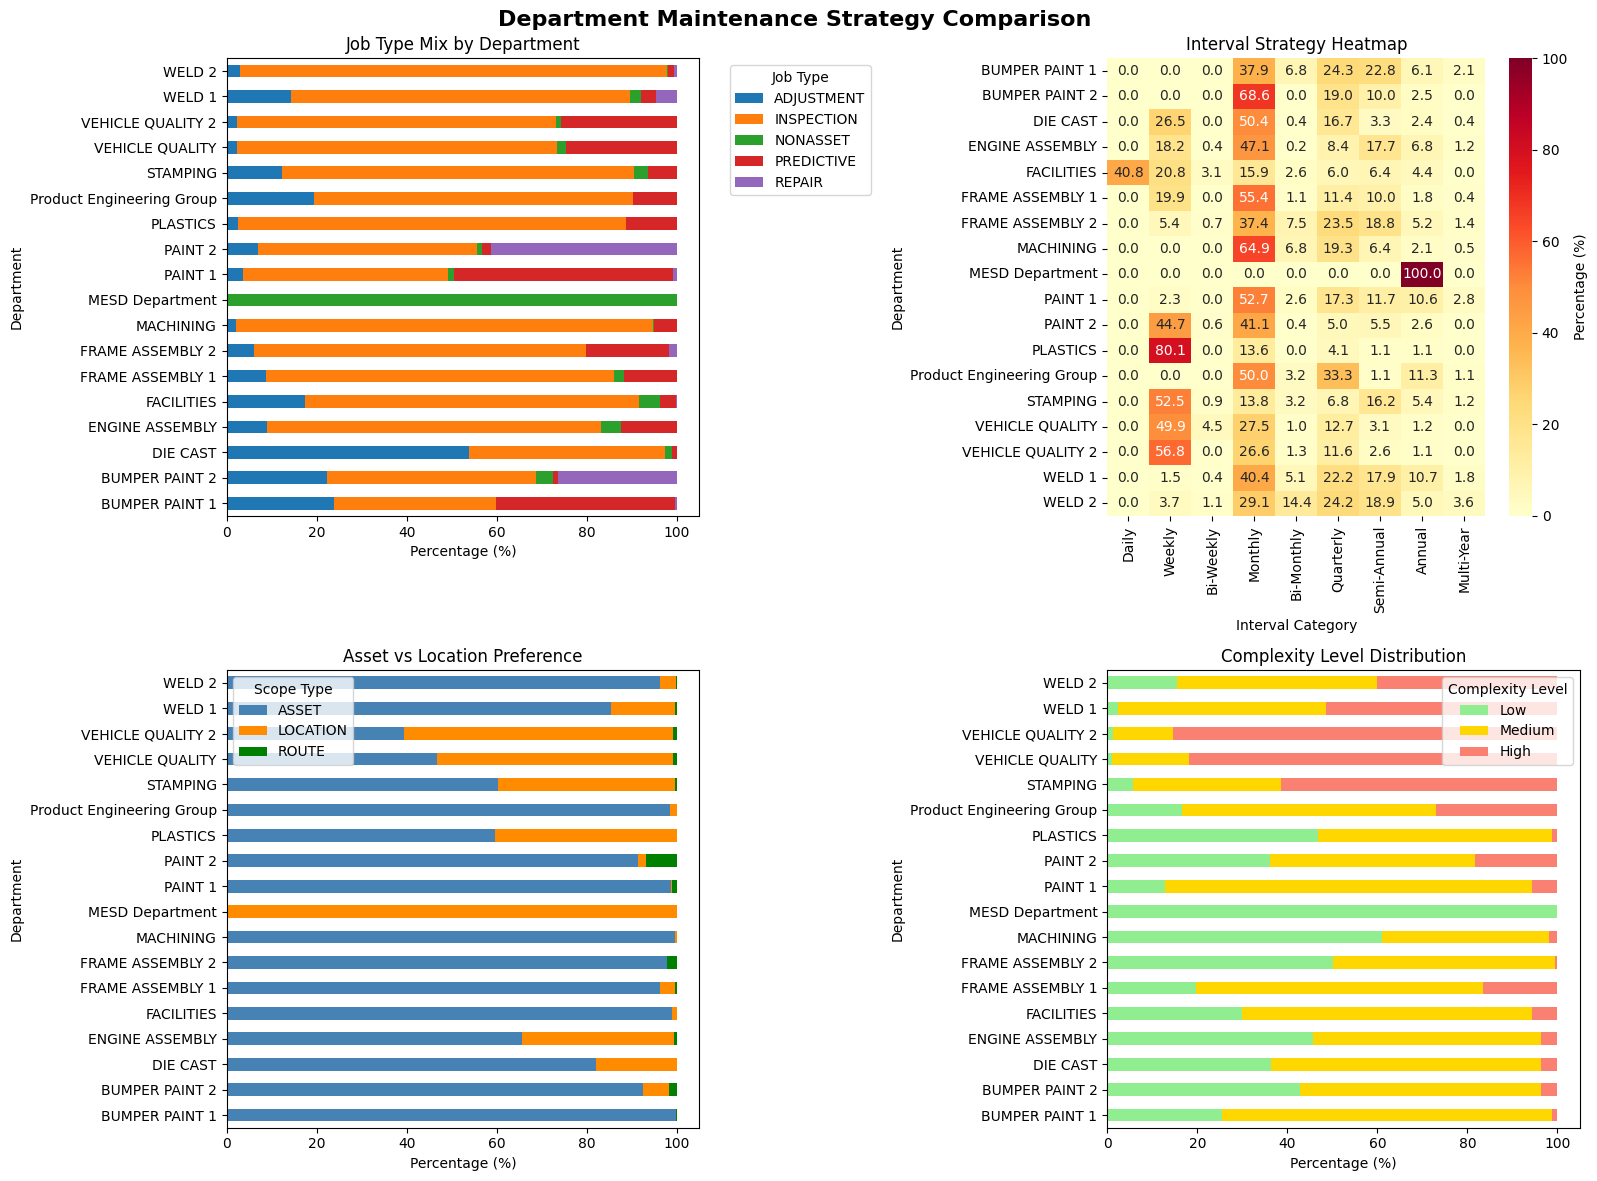

In [34]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Department Maintenance Strategy Comparison', fontsize=16, fontweight='bold')

# Chart 1: Job Type Mix (stacked bar)
ax1 = axes[0, 0]
job_type_pct.plot(kind='barh', stacked=True, ax=ax1)
ax1.set_xlabel('Percentage (%)')
ax1.set_ylabel('Department')
ax1.set_title('Job Type Mix by Department')
ax1.legend(title='Job Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Chart 2: Interval Strategy Heatmap
ax2 = axes[0, 1]
sns.heatmap(interval_pct, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Percentage (%)'})
ax2.set_xlabel('Interval Category')
ax2.set_ylabel('Department')
ax2.set_title('Interval Strategy Heatmap')

# Chart 3: Scope Type Preference
ax3 = axes[1, 0]
scope_pct.plot(kind='barh', stacked=True, ax=ax3, color=['steelblue', 'darkorange','green'])
ax3.set_xlabel('Percentage (%)')
ax3.set_ylabel('Department')
ax3.set_title('Asset vs Location Preference')
ax3.legend(title='Scope Type')

# Chart 4: Complexity Profile
ax4 = axes[1, 1]
complexity_pct.plot(kind='barh', stacked=True, ax=ax4, color=['lightgreen', 'gold', 'salmon'])
ax4.set_xlabel('Percentage (%)')
ax4.set_ylabel('Department')
ax4.set_title('Complexity Level Distribution')
ax4.legend(title='Complexity Level')

plt.tight_layout()
plt.show()

### 6. Craft Distribution

#### 6.1 Heat Map of Craft Utilization

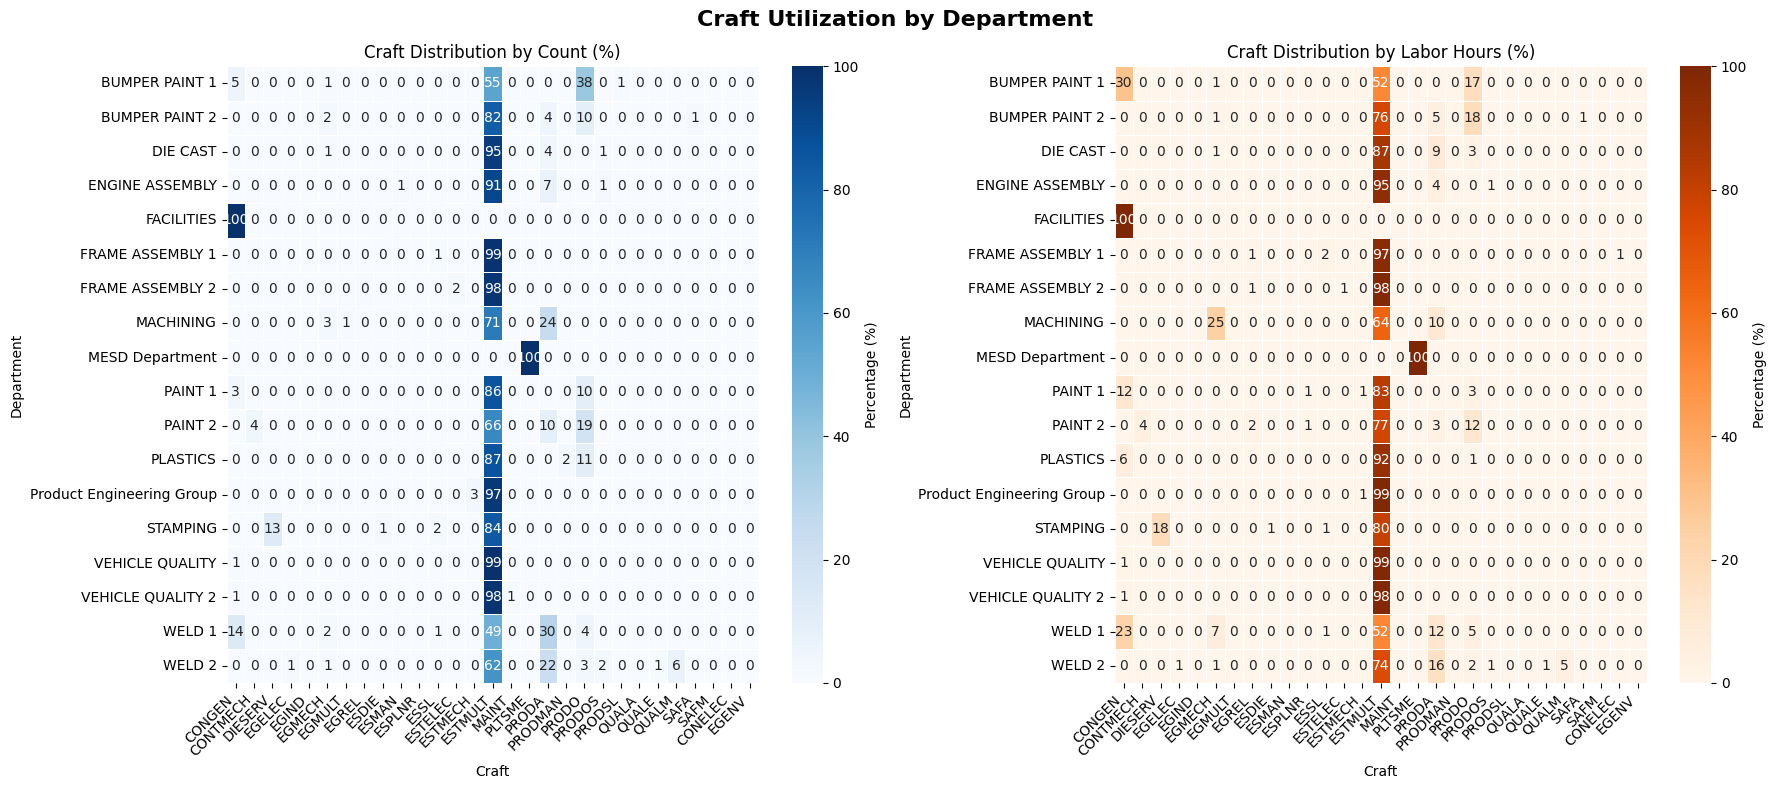

In [35]:
# Aggregate craft usage at department level
# Count-based distribution
craft_counts = df_forecast.groupby(['DEPT_NAME', 'LABOR_CRAFT'], observed=False).size().unstack(fill_value=0)
craft_pct = craft_counts.div(craft_counts.sum(axis=1), axis=0) * 100

# Labor-weighted distribution
craft_labor = df_forecast.groupby(['DEPT_NAME', 'LABOR_CRAFT'], observed=False)['total_labor_per_occ_capped'].sum().unstack(fill_value=0)
craft_labor_pct = craft_labor.div(craft_labor.sum(axis=1), axis=0) * 100

# Create heatmap visualizations
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Craft Utilization by Department', fontsize=16, fontweight='bold')

# Heatmap 1: Count-based
ax1 = axes[0]
sns.heatmap(craft_pct, annot=True, fmt='.0f', cmap='Blues', ax=ax1, 
            cbar_kws={'label': 'Percentage (%)'}, linewidths=0.5)
ax1.set_xlabel('Craft')
ax1.set_ylabel('Department')
ax1.set_title('Craft Distribution by Count (%)')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Heatmap 2: Labor hours-based
ax2 = axes[1]
sns.heatmap(craft_labor_pct, annot=True, fmt='.0f', cmap='Oranges', ax=ax2, 
            cbar_kws={'label': 'Percentage (%)'}, linewidths=0.5)
ax2.set_xlabel('Craft')
ax2.set_ylabel('Department')
ax2.set_title('Craft Distribution by Labor Hours (%)')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## PHASE III: Operational Philosophy

### 7 Department Operational Archetypes

#### 7.1 Department Characterization Summary 

In [36]:
# Aggregate key metrics per department
dept_profile = df_forecast.groupby('DEPT_NAME').agg({
    'COUNTKEY': 'nunique',  # PM volume
    'total_labor_per_occ_capped': 'sum',  # Total labor
    'complexity_score': 'mean',  # Average complexity
    'interval_days': 'mean'  # Average interval
}).rename(columns={
    'COUNTKEY': 'pm_volume',
    'total_labor_per_occ_capped': 'total_labor_hours',
    'complexity_score': 'avg_complexity',
    'interval_days': 'avg_interval_days'
})

# Add average hours per PM
dept_profile['avg_hours_per_pm'] = dept_profile['total_labor_hours'] / dept_profile['pm_volume']

# Add dominant job type
job_type_by_dept = df_forecast.groupby(['DEPT_NAME', 'JOB_TYPE'], observed = False).size().unstack(fill_value=0)
dept_profile['dominant_job_type'] = job_type_by_dept.idxmax(axis=1)
dept_profile['dominant_job_type_pct'] = job_type_by_dept.max(axis=1) / job_type_by_dept.sum(axis=1) * 100

# Add asset vs location preference
scope_by_dept = df_forecast.groupby(['DEPT_NAME', 'PMSCOPETYPE'], observed = False).size().unstack(fill_value=0)
if 'ASSET' in scope_by_dept.columns:
    dept_profile['asset_pct'] = scope_by_dept['ASSET'] / scope_by_dept.sum(axis=1) * 100
else:
    dept_profile['asset_pct'] = 0

print("\n-> Department Profile Metrics:")
display(dept_profile.round(2))


-> Department Profile Metrics:


,pm_volume,total_labor_hours,avg_complexity,avg_interval_days,avg_hours_per_pm,dominant_job_type,dominant_job_type_pct,asset_pct
DEPT_NAME,,,,,,,,
BUMPER PAINT 1,790,994.08,0.16,115.85,1.26,PREDICTIVE,39.57,99.75
BUMPER PAINT 2,970,1295.42,0.16,65.32,1.34,INSPECTION,46.32,92.40
DIE CAST,1533,3417.67,0.15,52.67,2.23,ADJUSTMENT,53.88,82.06
ENGINE ASSEMBLY,6820,22035.83,0.16,91.90,3.23,INSPECTION,74.11,65.69
FACILITIES,14540,33452.50,0.17,42.29,2.30,INSPECTION,74.14,98.94
FRAME ASSEMBLY 1,4935,7648.32,0.19,58.18,1.55,INSPECTION,77.33,96.21
FRAME ASSEMBLY 2,3810,9964.50,0.14,142.10,2.62,INSPECTION,73.76,97.75
MACHINING,4673,8430.25,0.13,65.80,1.80,INSPECTION,92.64,99.60
MESD Department,1,1.00,0.02,365.25,1.00,NONASSET,100.00,0.00


#### 7.2 Archetype Classification

In [37]:
# Exclude MESD Department (outlier with only 1 PM)
dept_profile_filtered = dept_profile[dept_profile['pm_volume'] > 10].copy()

# Define archetype based on avg_hours_per_pm and avg_complexity
def classify_archetype(row):
    hours = row['avg_hours_per_pm']
    complexity = row['avg_complexity']
    
    # Special case: Very low activity
    if row['pm_volume'] < 100:
        return "Specialty/Outlier"
    
    # Archetype 1: Lean Inspectors
    if hours < 2.0 and complexity < 0.20:
        return "Lean Inspectors"
    
    # Archetype 3: Intensive Maintainers
    elif hours > 3.0 or complexity > 0.20:
        return "Intensive Maintainers"
    
    # Archetype 2: Standard Maintenance (everything in between)
    else:
        return "Standard Maintenance"

dept_profile_filtered['archetype'] = dept_profile_filtered.apply(classify_archetype, axis=1)

# Display classification results
print("\n-> Department Archetype Classification:")
for archetype in ['Lean Inspectors', 'Standard Maintenance', 'Intensive Maintainers', 'Specialty/Outlier']:
    depts = dept_profile_filtered[dept_profile_filtered['archetype'] == archetype]
    if len(depts) > 0:
        print(f"\n{archetype.upper()} ({len(depts)} departments):")
        for dept in depts.index:
            row = depts.loc[dept]
            print(f"   • {dept}")
            print(f"     - {row['avg_hours_per_pm']:.2f} hrs/PM, Complexity: {row['avg_complexity']:.2f}, Interval: {row['avg_interval_days']:.0f} days")

# Summary statistics by archetype
print("\n-> Archetype Summary Statistics:")
archetype_summary = dept_profile_filtered.groupby('archetype').agg({
    'pm_volume': 'mean',
    'avg_hours_per_pm': 'mean',
    'avg_complexity': 'mean',
    'avg_interval_days': 'mean',
    'total_labor_hours': 'sum'
}).round(2)
display(archetype_summary)


-> Department Archetype Classification:

LEAN INSPECTORS (6 departments):
   • BUMPER PAINT 1
     - 1.26 hrs/PM, Complexity: 0.16, Interval: 116 days
   • BUMPER PAINT 2
     - 1.34 hrs/PM, Complexity: 0.16, Interval: 65 days
   • FRAME ASSEMBLY 1
     - 1.55 hrs/PM, Complexity: 0.19, Interval: 58 days
   • MACHINING
     - 1.80 hrs/PM, Complexity: 0.13, Interval: 66 days
   • PAINT 1
     - 1.81 hrs/PM, Complexity: 0.18, Interval: 118 days
   • PLASTICS
     - 1.60 hrs/PM, Complexity: 0.15, Interval: 19 days

STANDARD MAINTENANCE (4 departments):
   • DIE CAST
     - 2.23 hrs/PM, Complexity: 0.15, Interval: 53 days
   • FACILITIES
     - 2.30 hrs/PM, Complexity: 0.17, Interval: 42 days
   • FRAME ASSEMBLY 2
     - 2.62 hrs/PM, Complexity: 0.14, Interval: 142 days
   • PAINT 2
     - 2.37 hrs/PM, Complexity: 0.17, Interval: 41 days

INTENSIVE MAINTAINERS (7 departments):
   • ENGINE ASSEMBLY
     - 3.23 hrs/PM, Complexity: 0.16, Interval: 92 days
   • Product Engineering Group
     -

,pm_volume,avg_hours_per_pm,avg_complexity,avg_interval_days,total_labor_hours
archetype,,,,,
Intensive Maintainers,5901.14,2.85,0.24,86.18,91435.15
Lean Inspectors,2962.67,1.56,0.16,73.79,29552.52
Standard Maintenance,7544.75,2.38,0.16,69.49,71185.72


#### 7.3 Archetype Visualization

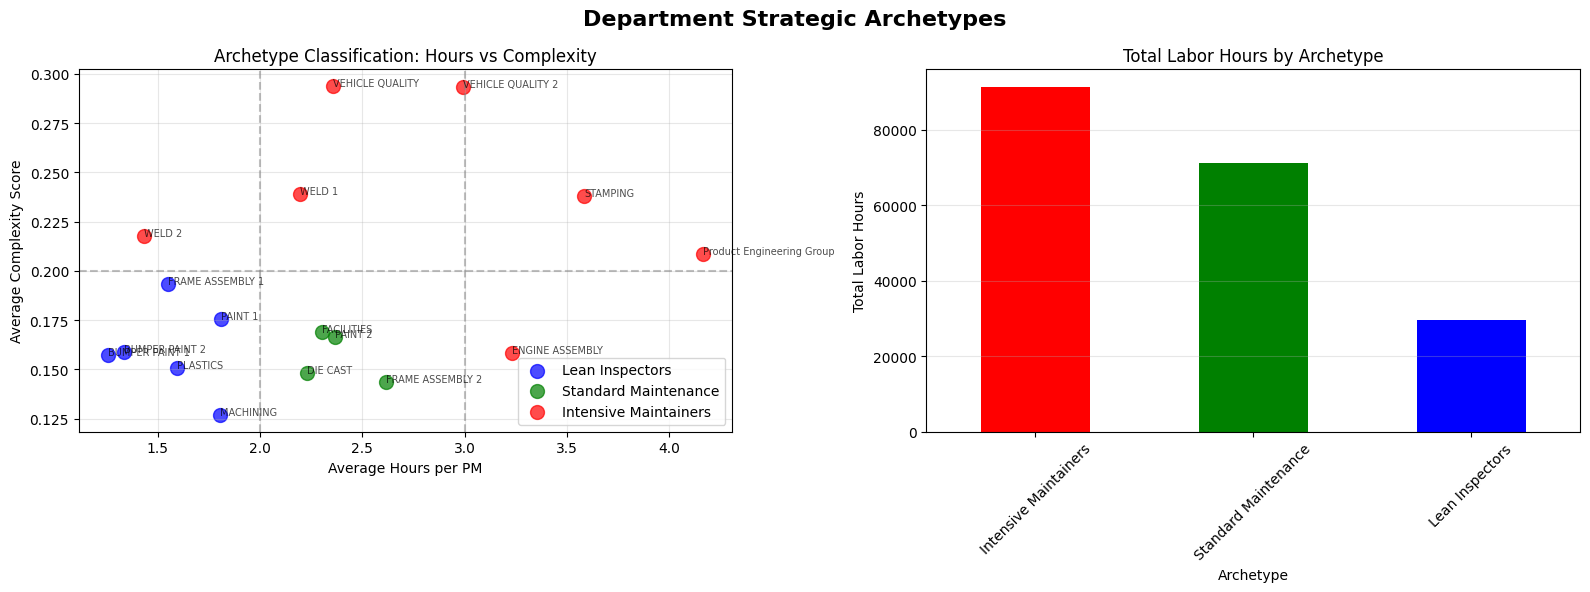

In [38]:
# Create scatter plot showing archetypes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Department Strategic Archetypes', fontsize=16, fontweight='bold')

# Chart 1: Scatter - Hours per PM vs Complexity (defining dimensions)
ax1 = axes[0]
colors = {'Lean Inspectors': 'blue', 'Standard Maintenance': 'green', 
          'Intensive Maintainers': 'red', 'Specialty/Outlier': 'gray'}

for archetype in dept_profile_filtered['archetype'].unique():
    data = dept_profile_filtered[dept_profile_filtered['archetype'] == archetype]
    ax1.scatter(data['avg_hours_per_pm'], data['avg_complexity'], 
                s=100, alpha=0.7, label=archetype, color=colors.get(archetype, 'black'))

ax1.set_xlabel('Average Hours per PM')
ax1.set_ylabel('Average Complexity Score')
ax1.set_title('Archetype Classification: Hours vs Complexity')
ax1.legend()
ax1.grid(alpha=0.3)

# Add boundary lines
ax1.axvline(x=2.0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=3.0, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=0.20, color='gray', linestyle='--', alpha=0.5)

# Add department labels
for dept, row in dept_profile_filtered.iterrows():
    ax1.annotate(dept, (row['avg_hours_per_pm'], row['avg_complexity']),
                fontsize=7, alpha=0.7)

# Chart 2: Bar chart - Total labor hours by archetype
ax2 = axes[1]
archetype_labor = dept_profile_filtered.groupby('archetype')['total_labor_hours'].sum().sort_values(ascending=False)
archetype_labor.plot(kind='bar', ax=ax2, color=[colors.get(x, 'black') for x in archetype_labor.index])
ax2.set_xlabel('Archetype')
ax2.set_ylabel('Total Labor Hours')
ax2.set_title('Total Labor Hours by Archetype')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()